Typography: Don’t bold everything. 
Use normal weight; reserve bold for panel letters or key labels. Set fonts before plotting.
COLOR BLIND FRIENDLY: GIST EART!! NOT TERRAIN

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from wrf import getvar, latlon_coords
from wrf import to_np

# Load WRF Output Files
ncfile1 = Dataset("/Volumes/Ann/wrf_large_domain/wrf_d01/wrfout_d01_2008-03-06_13:00:00")
#Load Domain 2 and Domain 3 Boundary file for domain marking
ncfile1a = Dataset("/Volumes/Ann/wrf_large_domain/wrf_D02/wrfout_d02_2008-03-06_13:00:00")
ncfile1b = Dataset("/Volumes/Ann/wrf_large_domain/wrfout_d03_2008-03-07_03:00:00")

# Function to extract terrain and coordinates
def extract_terrain(ncfile):
    terrain = getvar(ncfile, "ter", timeidx=-1)
    lats, lons = latlon_coords(terrain)
    return terrain, lats, lons

terrain1, lat1, lon1 = extract_terrain(ncfile1)
terrain1a, lat1a, lon1a = extract_terrain(ncfile1a)
terrain1b, lat1b, lon1b = extract_terrain(ncfile1b)


# Function to extract domain boundary coordinates
''' lats[0, :] : Top row (northern edge)
All longitudes at the first row (lat fixed, lon varies left → right)
lats[:, -1]: Right column (eastern edge)
All latitudes at the last column (lon fixed, lat varies top → bottom)
lats[-1, ::-1]: Bottom row (southern edge), reversed
All longitudes at the last row, from right → left (to follow the polygon clockwise)
lats[::-1, 0]: Left column (western edge), reversed
All latitudes at the first column, from bottom → top'''
def extract_domain_boundary(ncfile):
    _, lats, lons = extract_terrain(ncfile)
    lat_bounds = np.concatenate([lats[0, :], lats[:, -1], lats[-1, ::-1], lats[::-1, 0]])
    lon_bounds = np.concatenate([lons[0, :], lons[:, -1], lons[-1, ::-1], lons[::-1, 0]])
    return lat_bounds, lon_bounds
lat_bounds1a, lon_bounds1a = extract_domain_boundary(ncfile1a)
lat_bounds1b, lon_bounds1b = extract_domain_boundary(ncfile1b)

# Locations for stations
locations = {
    "HEB": (27.2993, -98.70),
    "BEV": (28.3904, -97.77083),
    "VCT": (28.7000, -97.0200),
    "SGR": (29.5200, -95.6929),
    "LCH": (30.1692, -93.2961),
    "LFT": (30.1442, -92.0996),
    "GWO": (33.4749, -90.2345),
    "MSL": (34.768080, -87.665565),
    "LEX" : (37.909837, -84.64152),
    "NEW" : (29.904202, -89.886204),
    "BFM" : (30.618202, -88.079858),
    "BHM":(33.4186,-86.92008)
}
radiosonde= {
    "DRT": (29.36, -100.91),
    "BRO": (25.91,-97.41),
    "FWD": (32.83,-97.30),
    "LIX": (30.33, -89.77),
}
both= {"JAN": (32.31, -90.08),
        "BNA": (36.25, -86.57),
        "ILN": (39.41, -83.81)
}

In [2]:
# print he maximum and minimum values of the terrain for all domains
max_height = np.max(terrain1)
min_height = np.min(terrain1)
print(f"Max height1: {np.max(terrain1)} m")


Max height1: <xarray.DataArray 'terrain' ()> Size: 4B
array(3767.0552, dtype=float32)
Coordinates:
    XTIME    float32 4B 0.0
    Time     datetime64[ns] 8B 2008-03-06T13:00:00 m


1) In Matplotlib (and Cartopy, which uses it under the hood), every visual element — contours, coastlines, fills, gridlines, markers, etc. — is assigned a drawing order value called zorder.
Low zorder values → drawn first (underneath)
High zorder values → drawn later (on top)

2) label the transect
3) keep the ocean white if you don't need it: The best way to do this is by setting the clabel from the 0 instead of -10 to the hightest value
4) ↑ (drawn last, on top)
|  Stations, labels (zorder=6–7)
|  Coastlines (zorder=5)
|  Terrain shading (zorder=2)
|  Land outlines (zorder=1)
|  Ocean (zorder=0)
↓ (drawn first, bottom layer)

5) add halo with patheffect.withStroke
6) Also zoom in at the end after the contour labeling that way you'll have control over the label markers)
Optional: set a clean extent (lon_min, lon_max, lat_min, lat_max)
 ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
7) Coarser filled levels; thin line contours for structure
8) Gridlines: When you use gridlines(draw_labels=True), Cartopy draws its own label objects on the map (not axis tick labels). Those gridline labels are already formatted as °N/°S/°E/°W
Instead: The set_major_formatter(...) lines only affect axis tick labels (what you’d see if you relied on Matplotlib ticks instead of Cartopy’s gridline labels).
89) Always check cbar fills and cbar ticks

In [5]:

'''Offshore'''
# Define cross-section line 2: Matagorda Island to Iberia Parish
lonxx, latxx =  -96.598246, 28.26130# Start point
lonyy, latyy = -91.914934, 29.550885 # End point

'''ETC Spectrum'''
# Define cross-section line 3
lonxxx, latxxx  = -95.634284, 29.599416
lonyyy, latyyy  = -86.796281, 33.503618

'''CSI'''
# trasect horizontal
lonx6, latx6 = -92.027429, 29.216570 # Start point
lony7, laty7 = -92.08663, 34.449276  # End


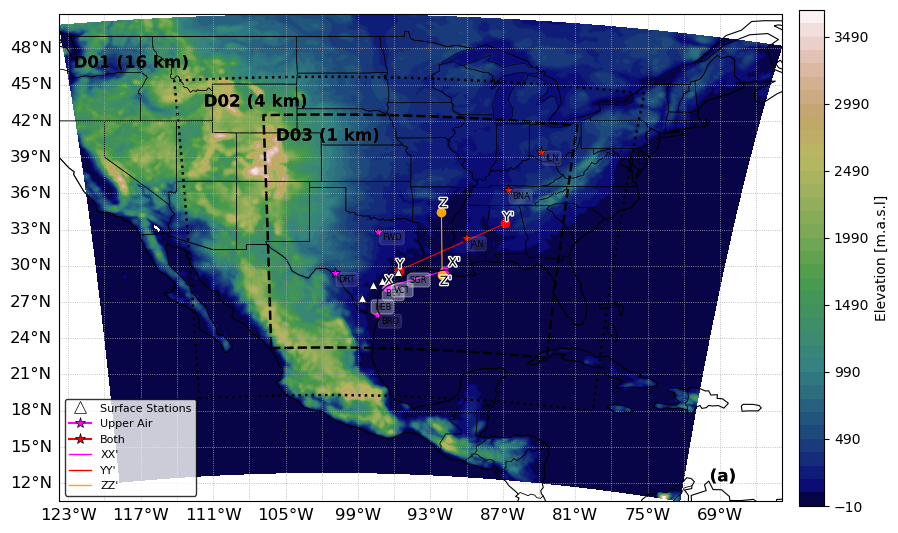

In [65]:
# so many new features: mticker, LongitudeFormatter, LatitudeFormatter, LightSource, patheffects
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LightSource
import numpy as np
import matplotlib.patheffects as pe

# Style settings
plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "font.weight": "normal",
    "axes.titleweight": "bold",
    "savefig.dpi": 600,
})

# Figure and axis with Cartopy projection
fig, ax = plt.subplots(
    figsize=(9.5, 6.5),  # tighter aspect for print columns
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Basemap features
ax.add_feature(cfeature.LAND.with_scale("110m"), facecolor="none")
ax.add_feature(cfeature.OCEAN.with_scale("110m"), facecolor="white")
ax.add_feature(cfeature.COASTLINE.with_scale("110m"), linewidth=0.8, zorder=5)
ax.add_feature(cfeature.BORDERS.with_scale("110m"), linewidth=0.6)
ax.add_feature(cfeature.STATES.with_scale("110m"), linewidth=0.4)  # US states; harmless elsewhere


# Contoured filled terrain with colormap
cfill_levels = np.arange(-10, np.max(terrain1), 100)
cfill = ax.contourf(lon1, lat1, terrain1, levels=cfill_levels, cmap='gist_earth',
                    transform=ccrs.PlateCarree(), extend="neither", alpha=0.98)

#Domain bounds and transects
ax.plot(lon_bounds1a, lat_bounds1a, color="k", linestyle=":", linewidth=1.8, transform=ccrs.PlateCarree())
ax.plot(lon_bounds1b, lat_bounds1b, color="k", linestyle="--", linewidth=1.8, transform=ccrs.PlateCarree())
ax.plot([lonxx, lonyy], [latxx, latyy], color='magenta', linewidth=0.8, marker='o',transform=ccrs.Geodetic(), label='Transect Line')
ax.plot([lonxxx, lonyyy], [latxxx, latyyy], color='red', linewidth=0.8, marker='o',transform=ccrs.Geodetic(), label='Transect Line')
ax.plot([lonx6, lony7], [latx6, laty7], color='orange', linewidth=0.8, marker='o',transform=ccrs.Geodetic(), label='Transect Line')
ax.text(0.02, 0.9, "D01 (16 km)", transform=ax.transAxes,
        ha="left", va="center",
        fontsize=12, fontweight="bold", color="black",
        path_effects=[pe.withStroke(linewidth=0.1, foreground="white")],
        zorder=10)
ax.text(0.20, 0.82, "D02 (4 km)", transform=ax.transAxes,
        ha="left", va="center",
        fontsize=12, fontweight="bold", color="black",
        path_effects=[pe.withStroke(linewidth=0.1, foreground="white")],
        zorder=10)
ax.text(0.3, 0.75, "D03 (1 km)", transform=ax.transAxes,
        ha="left", va="center",
        fontsize=12, fontweight="bold", color="black",
        path_effects=[pe.withStroke(linewidth=0.1, foreground="white")],
        zorder=10)
# Label transects 
ax.text(lonxx - 0.2, latxx + 0.2, "X", transform=ccrs.PlateCarree(), fontsize=9,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(lonyy + 0.4, latyy + 0.4, "X'", transform=ccrs.PlateCarree(), fontsize=9,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(lonxxx - 0.2, latxxx + 0.2, "Y", transform=ccrs.PlateCarree(), fontsize=9,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(lonyyy - 0.2, latyyy + 0.2, "Y'", transform=ccrs.PlateCarree(), fontsize=9,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(lonx6 - 0.2, latx6 - 0.8, "Z'", transform=ccrs.PlateCarree(), fontsize=9,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(lony7 - 0.2, laty7 + 0.4, "Z", transform=ccrs.PlateCarree(), fontsize=9,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])

# Plot locations
for location, (lat_city, lon_city) in locations.items():
        # Plot markers (white filled, black border)
        ax.plot(lon_city, lat_city, marker='^', markeredgecolor='black', markeredgewidth=0.5, 
                color='white', markersize=6, transform=ccrs.PlateCarree())

        # Add text labels with a background for better readability
        ax.text(lon_city + 1, lat_city - 0.7, location, transform=ccrs.PlateCarree(),
                ha='left', va='center', fontsize=6, color='black',
                bbox=dict(facecolor='white', edgecolor='white', alpha=0.3, boxstyle='round,pad=0.3'))

for location, (lat_city, lon_city) in radiosonde.items():
        # Plot markers (white filled, black border)
        ax.plot(lon_city, lat_city, marker='*', markeredgecolor='black', markeredgewidth=0.5, 
                color='magenta', markersize=8, transform=ccrs.PlateCarree())
        # Add text labels with a background for better readability
        ax.text(lon_city + 0.3 , lat_city- 0.5, location, transform=ccrs.PlateCarree(),
                ha='left', va='center', fontsize=6, color='black',
                bbox=dict(facecolor='white', edgecolor='white', alpha=0.1, boxstyle='round,pad=0.3'))

for location, (lat_city, lon_city) in both.items():
        # Plot markers (white filled, black border)
        ax.plot(lon_city, lat_city, marker='*', markeredgecolor='black', markeredgewidth=0.5, 
                color='red', markersize=8, transform=ccrs.PlateCarree())
        # Add text labels with a background for better readability
        ax.text(lon_city + 0.3 , lat_city- 0.5, location, transform=ccrs.PlateCarree(),
                ha='left', va='center', fontsize=6, color='black',
                bbox=dict(facecolor='white', edgecolor='white', alpha=0.1, boxstyle='round,pad=0.3'))
        
handles = [
    plt.Line2D([0], [0], marker='^', color='white', markersize=8, markerfacecolor='white', markeredgecolor='black', markeredgewidth=0.5, label='Surface Stations'),
    plt.Line2D([0], [0], marker='*', color='magenta', markersize=8, markerfacecolor='magenta', markeredgecolor='black', markeredgewidth=0.5, label='Upper Air'),
    plt.Line2D([0], [0], marker='*', color='red', markersize=8, markerfacecolor='red', markeredgecolor='black', markeredgewidth=0.5, label='Both'),
    plt.Line2D([0], [0], color="magenta", ls='solid', lw=1, label="XX'"),
    plt.Line2D([0], [0], color="red", ls='solid', lw=1, label="YY'"),
    plt.Line2D([0], [0], color="orange", ls='solid', lw=1, label="ZZ'"),
]
legend = ax.legend(handles=handles, loc='lower left', fontsize=8, frameon=True, edgecolor='black', facecolor='white')

# GRIDLINES & TICKS 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.6, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.MultipleLocator(3)   # adjust to your map scale
gl.ylocator = mticker.MultipleLocator(3)
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# COLORBAR: SHRINK LESS SO SAME SIZE!!!
# Notice the cbar ticks first
cbar = plt.colorbar(cfill, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label("Elevation [m.a.s.l]", fontsize=10)
cbar.set_ticks(np.arange(-10, np.max(terrain1), 500))

# Label the figure
ax.text(0.9, 0.05, "(a)", transform=ax.transAxes,
        ha="left", va="center",
        fontsize=12, fontweight="bold", color="black",
        path_effects=[pe.withStroke(linewidth=0.1, foreground="white")],
        zorder=10)
#ax.set_title("Topography, WRF Domains, and Observation Sites", pad=6)

# Save for print:
plt.tight_layout()
plt.savefig("figure_domains_topography.pdf")      # vector for MWR
plt.savefig("figure_domains_topography.png", dpi=600, bbox_inches="tight")
plt.show()


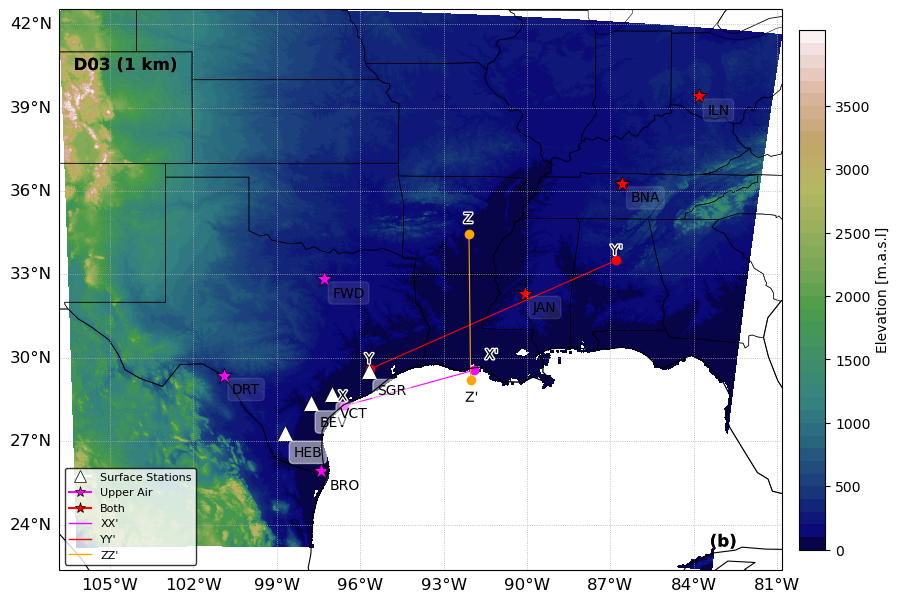

In [66]:

fig, ax = plt.subplots(
    figsize=(9.5, 6.5),  # tighter aspect for print columns
    subplot_kw={"projection": ccrs.PlateCarree()}
)

ax.add_feature(cfeature.LAND.with_scale("110m"), facecolor="none")
ax.add_feature(cfeature.OCEAN.with_scale("110m"), facecolor="white")
ax.add_feature(cfeature.COASTLINE.with_scale("110m"), linewidth=0.8, zorder=5)
ax.add_feature(cfeature.BORDERS.with_scale("110m"), linewidth=0.6)
ax.add_feature(cfeature.STATES.with_scale("110m"), linewidth=0.4)  # US states; harmless elsewhere

cfill_levels = np.arange(0, np.max(terrain1b), 100)
cfill = ax.contourf(lon1b, lat1b, terrain1b, levels=cfill_levels, cmap="gist_earth",
                    transform=ccrs.PlateCarree(), extend="neither", alpha=0.98)
ax.plot([lonxx, lonyy], [latxx, latyy], color='magenta', linewidth=0.8, marker='o',transform=ccrs.Geodetic(), label='Transect Line')
ax.plot([lonxxx, lonyyy], [latxxx, latyyy], color='red', linewidth=0.8, marker='o',transform=ccrs.Geodetic(), label='Transect Line')
ax.plot([lonx6, lony7], [latx6, laty7], color='orange', linewidth=0.8, marker='o',transform=ccrs.Geodetic(), label='Transect Line')
ax.text(0.02, 0.9, "D03 (1 km)", transform=ax.transAxes,
        ha="left", va="center",
        fontsize=12, fontweight="bold", color="black",
        path_effects=[pe.withStroke(linewidth=0.1, foreground="white")],
        zorder=10)
# Label transects lightly
ax.text(lonxx - 0.2, latxx + 0.2, "X", transform=ccrs.PlateCarree(), fontsize=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(lonyy + 0.4, latyy + 0.4, "X'", transform=ccrs.PlateCarree(), fontsize=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(lonxxx - 0.2, latxxx + 0.2, "Y", transform=ccrs.PlateCarree(), fontsize=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(lonyyy - 0.2, latyyy + 0.2, "Y'", transform=ccrs.PlateCarree(), fontsize=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(lonx6 - 0.2, latx6 - 0.8, "Z'", transform=ccrs.PlateCarree(), fontsize=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(lony7 - 0.2, laty7 + 0.4, "Z", transform=ccrs.PlateCarree(), fontsize=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(0.9, 0.05, "(b)", transform=ax.transAxes,
        ha="left", va="center",
        fontsize=12, fontweight="bold", color="black",
        path_effects=[pe.withStroke(linewidth=0.1, foreground="white")],
        zorder=10)

# Plot locations
for location, (lat_city, lon_city) in locations.items():
        # Plot markers (white filled, black border)
        ax.plot(lon_city, lat_city, marker='^', markeredgecolor='black', markeredgewidth=0.5, 
                color='white', markersize=12, transform=ccrs.PlateCarree())

        # Add text labels with a background for better readability
        ax.text(lon_city + 0.3, lat_city - 0.7, location, transform=ccrs.PlateCarree(),
                ha='left', va='center', fontsize=10, color='black',
                bbox=dict(facecolor='white', edgecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))


for location, (lat_city, lon_city) in radiosonde.items():
        # Plot markers (white filled, black border)
        ax.plot(lon_city, lat_city, marker='*', markeredgecolor='black', markeredgewidth=0.5, 
                color='magenta', markersize=12, transform=ccrs.PlateCarree())
        # Add text labels with a background for better readability
        ax.text(lon_city + 0.3 , lat_city- 0.5, location, transform=ccrs.PlateCarree(),
                ha='left', va='center', fontsize=10, color='black',
                bbox=dict(facecolor='white', edgecolor='white', alpha=0.1, boxstyle='round,pad=0.3'))


for location, (lat_city, lon_city) in both.items():
        # Plot markers (white filled, black border)
        ax.plot(lon_city, lat_city, marker='*', markeredgecolor='black', markeredgewidth=0.5, 
                color='red', markersize=12, transform=ccrs.PlateCarree())
        # Add text labels with a background for better readability
        ax.text(lon_city + 0.3 , lat_city- 0.5, location, transform=ccrs.PlateCarree(),
                ha='left', va='center', fontsize=10, color='black',
                bbox=dict(facecolor='white', edgecolor='white', alpha=0.1, boxstyle='round,pad=0.3'))
        
handles = [
    plt.Line2D([0], [0], marker='^', color='white', markersize=8, markerfacecolor='white', markeredgecolor='black', markeredgewidth=0.5, label='Surface Stations'),
    plt.Line2D([0], [0], marker='*', color='magenta', markersize=8, markerfacecolor='magenta', markeredgecolor='black', markeredgewidth=0.5, label='Upper Air'),
    plt.Line2D([0], [0], marker='*', color='red', markersize=8, markerfacecolor='red', markeredgecolor='black', markeredgewidth=0.5, label='Both'),
    plt.Line2D([0], [0], color="magenta", ls='solid', lw=1, label="XX'"),
    plt.Line2D([0], [0], color="red", ls='solid', lw=1, label="YY'"),
    plt.Line2D([0], [0], color="orange", ls='solid', lw=1, label="ZZ'"),
]
legend = ax.legend(handles=handles, loc='lower left', fontsize=8, frameon=True, edgecolor='black', facecolor='white')

# Gridlines & Ticks
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.6, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.MultipleLocator(3)   # adjust to your map scale
gl.ylocator = mticker.MultipleLocator(3)
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Colobar: check ticks first
cbar = plt.colorbar(cfill, ax=ax, orientation='vertical', shrink=0.85, pad=0.02)
cbar.set_label("Elevation [m.a.s.l]", fontsize=10)
cbar.set_ticks(np.arange(0, np.max(terrain1), 500))
plt.tight_layout()

# Save for print:
plt.savefig("figure_domains_topography_close_up.pdf")      # vector for MWR
plt.savefig("figure_domains_topography_close_up.png", dpi=600, bbox_inches="tight")
plt.show()